In [1]:
import nltk
import os
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re, string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

#

In [2]:
nltk.download([
'punkt',
'wordnet',
'averaged_perceptron_tagger',
'stopwords',
'omw-1.4'
])

[nltk_data] Downloading package punkt to /home/ahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ahmed/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/ahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ahmed/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
def get_tokens(list):#list of reviews
    tokens = []
    for review in list:
        tokens.append(word_tokenize(review))
    return tokens

In [4]:
def remove_stop_words(tokens):# list of tokens
    new_list = []
    stop_words = set(stopwords.words('english'))
    for w in tokens:
        if w not in stop_words:
            new_list.append(w)
    
    return new_list

In [5]:

def remove_noise(tokens):

    cleaned_tokens = []
    for token, tag in pos_tag(tokens):
            
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if token not in string.punctuation and token.isalpha():
            cleaned_tokens.append(token)

    return cleaned_tokens

In [6]:
def join_tokens(tokens):
    return ' '.join(tokens)

In [7]:
def pre_processing(lst):# lst of reviews
    new_lst = []

    new_lst = get_tokens(lst)

    new_lst = [remove_noise(tokens) for tokens in new_lst]

    new_lst = [remove_stop_words(tokens) for tokens in new_lst]

    new_lst = [join_tokens(tokens) for tokens in new_lst]

    return new_lst


In [8]:
def get_top_n_words(text_counts,count_vectorizer,n=15):
    sum_words = text_counts.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in  count_vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
    

In [9]:
def top_tfidf_feats(row, features, n = 15):
    feature_array = np.array(features.get_feature_names())
    tfidf_sorting = np.argsort(row.toarray()).flatten()[::-1]

    top_n = feature_array[tfidf_sorting][:n]
    return top_n

In [10]:
# read data from files
positive_reviews = []
negative_reviews = []

for path in os.scandir('./data/pos'):
    if path.is_file():
        f = open(path,'r')
        positive_reviews.append(f.read().lower())


for path in os.scandir('./data/neg'):
    if path.is_file():
        f = open(path,'r')
        negative_reviews.append(f.read().lower())

print(len(positive_reviews))
print(len(negative_reviews))

1000
1000


In [11]:

positive_tokens = pre_processing(positive_reviews)
negative_tokens = pre_processing(negative_reviews)


In [12]:
data = pd.DataFrame()
data['reviews'] = positive_tokens + negative_tokens

zeros = np.zeros(len(positive_tokens),dtype=int) 
ones = np.ones(len(negative_tokens),dtype=int)

data['sentiment'] = np.append(zeros,ones)
print(data)

                                                reviews  sentiment
0     film come see year think chase amy many moment...          0
1     john carpenter direct stylish gory vampire fli...          0
2     film adapt comic book plenty success whether s...          0
3     every movie come along suspect studio every in...          0
4     get mail work alot good deserve order make fil...          0
...                                                 ...        ...
1995  anything stigmata take warning release film re...          1
1996  john boorman zardoz goofy cinematic debacle fu...          1
1997  kid hall acquired taste take least season watc...          1
1998  time john carpenter great horror director cour...          1
1999  two party guy bob head haddaway dance hit love...          1

[2000 rows x 2 columns]


In [13]:
#feature extraction using Bag of Words
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1))
text_counts= cv.fit_transform(data['reviews'])


X_train, X_test, y_train, y_test = train_test_split(
    text_counts, data['sentiment'], test_size=0.3, shuffle=True)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)

BOW_ACCS = metrics.accuracy_score(y_test, predicted)

print("Bag of Words Accuracy:",BOW_ACCS)


print(get_top_n_words(text_counts,cv,10))

Bag of Words Accuracy: 0.805
[('film', 11073), ('movie', 6861), ('make', 4129), ('character', 3854), ('like', 3811), ('good', 3238), ('time', 2849), ('scene', 2625), ('story', 2321), ('play', 2298)]


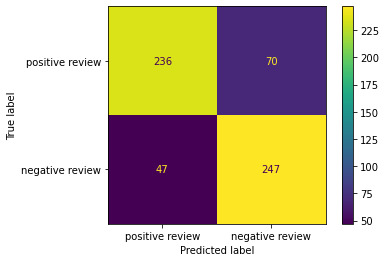

In [14]:
# drawing Bag of Word confussion matrix
conf_matrix = confusion_matrix(y_test,predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                               display_labels=['positive review','negative review'])

disp.plot()

In [15]:
#feature extraction using tf-idf

tf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

text_tf= tf.fit_transform(data['reviews'])

X_train, X_test, y_train, y_test = train_test_split(
    text_tf, data['sentiment'], test_size=0.3,shuffle=True)


clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)

TFIDF_ACCS = metrics.accuracy_score(y_test, predicted)

print("TF-IDF Accuracy:",TFIDF_ACCS)

print(top_tfidf_feats(text_tf,tf,10))



TF-IDF Accuracy: 0.805
['skit' 'sketch' 'bob' 'club' 'doug' 'guy' 'steve' 'nightclub' 'bump'
 'presumably']


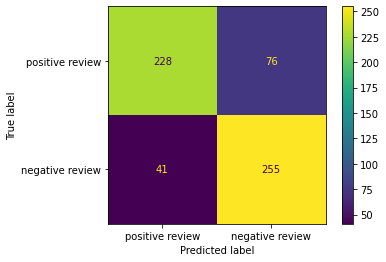

In [16]:
# drawing tf-idf confusion matrix

conf_matrix = confusion_matrix(y_test,predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                               display_labels=['positive review','negative review'])

disp.plot()

In [17]:
# feature extraction using 2 ngram
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (2,2))
text_counts= cv.fit_transform(data['reviews'])

X_train, X_test, y_train, y_test = train_test_split(
    text_counts, data['sentiment'], test_size=0.3, shuffle=True)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)

TWO_GRAM_ACCS = metrics.accuracy_score(y_test, predicted)

print("2 gram of Words Accuracy:",TWO_GRAM_ACCS)

print(get_top_n_words(text_counts,cv,10))


2 gram of Words Accuracy: 0.7066666666666667
[('special effect', 386), ('look like', 322), ('new york', 249), ('film like', 214), ('make film', 187), ('bad guy', 183), ('high school', 178), ('movie like', 170), ('star war', 165), ('film make', 162)]


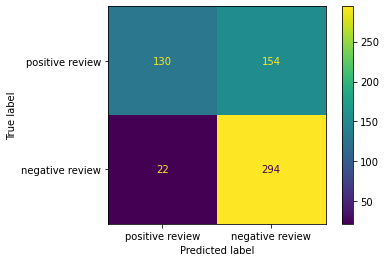

In [18]:
conf_matrix = confusion_matrix(y_test,predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                               display_labels=['positive review','negative review'])

disp.plot()

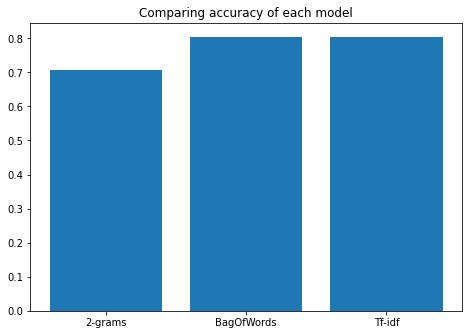

['2-grams', 'BagOfWords', 'Tf-idf']
[0.7066666666666667, 0.805, 0.805]


In [19]:
fig =  plt.figure()
ax = fig.add_axes([0,0,1,1])

plt.title('Comparing accuracy of each model')

models_labels = ['2-grams','BagOfWords','Tf-idf']
models_accs = [TWO_GRAM_ACCS,BOW_ACCS,TFIDF_ACCS]

ax.bar(models_labels,models_accs)
plt.show()

print(models_labels)
print(models_accs)
